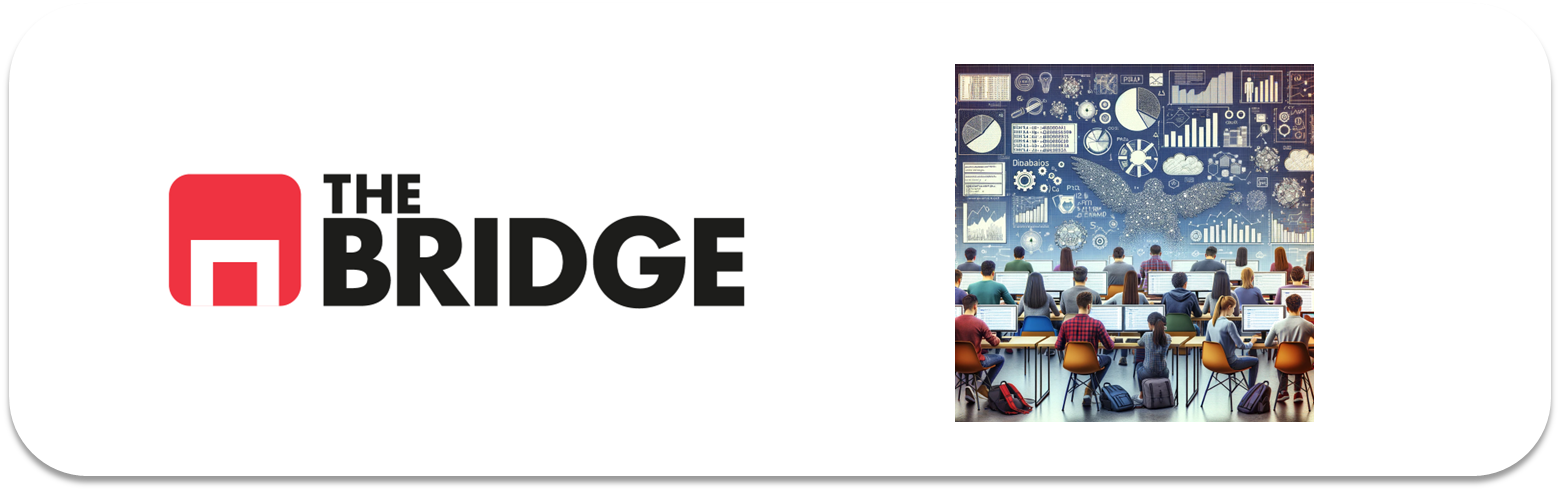

## TEAM CHALLENGE: PIPELINES

Este notebook describe el Team Challenge dedicado a la práctica y construcción de Pipelines de Scikit-learn que deberéis presentar en clase dentro de dos sprints.

Se trata de un Team Challenge muy abierto, ya que podéis elegir vuestro caso de uso y, por tanto, los datos que usaréis para entrenar y testear vuestros Pipelines, pero de forma general se valorarán positivamente los siguientes puntos:

* Usar Pipelines  

* Usar Estimadores Supervisados y No Supervisados  

* Usar OneHotEncoder de forma que no haya errores si una variable categórica tiene valores que aparecen o no aparecen en train y test

* Usar validación cruzada y explicar la gran ventaja de los Pipelines en validación cruzada (pensad en qué puede ser ;) )  

* Usar GridsearchCV  

* Usar Entornos Virtuales para el desarrollo y ejecución del código (incluyendo sus respectivos archivos `requirements.txt` y `.gitignore`)

* Opcional: Calcular alguna regresión donde el target no esté distribuido de forma gaussiana  

* Opcional: Calcular alguna clasificación donde el target esté desbalanceado (¡ojo!)  

### Consejos:

En caso de querer refrescar la memoria, recordad que la construcción de Pipelines de Scikit-learn se trató durante la Live Review 1 del Sprint 15, por lo que podéis consultar el material de la sesión y los notebooks disponibles en el repositorio de ejercicios.

Así mismo, aquí os dejamos estos dos enlaces que os pueden ayudar mucho a evitar errores comunes durante el preprocesado de datos:

> https://scikit-learn.org/stable/common_pitfalls.html
>
> https://imbalanced-learn.org/stable/common_pitfalls.html

Si os fijáis, el segundo enlace es de Imbalanced Learn (No Scikit-learn)

### Entregables  

Para una entrega válida de este Team Challenge, se piden los siguientes entregables mínimos:  

1. Realizar todo el desarrollo en un repositorio de GitHub específico para este Team Challenge. Como en casos anteriores, uno de los integrantes del grupo debe crear el repositorio y añadir a los demás integrantes como colaboradores.

2. Dicho repositorio debe contener:  
    - Un archivo `README.md` sencillo que especifique el nombre del grupo, los integrantes del mismo y explique la estructura de ficheros del repositorio, así como el objetivo de este Team Challenge. (Opcional) En caso de haber usado un Entorno Virtual durante el desarrollo, es interesante que dentro de este archivo `README.md` hagáis referencia a la versión de Python utilizada y a dónde se pueden encontrar las dependencias del proyecto, así como las instrucciones para la descarga y ejecución del código en caso de que alguien quiera probar vuestro proyecto.

    - Un directorio `/src/data` con los ficheros `<nombre_dataset>_train.csv` y `<nombre_dataset>_test.csv` de vuestra elección que se usarán para el desarrollo del Team Challenge.

    - Un directorio `/src/result_notebooks` que contenga:  

        * El notebook `<nombre_grupo>_Pipelines_I.ipynb` que contenga el código comentado que implemente la construcción de vuestro pipeline. El notebook debe poder ejecutarse completo y sin errores, y al finalizar debe guardar el modelo entrenado en un directorio `/src/models`.  

        * El notebook `<nombre_grupo>_Pipelines_II.ipynb` que contenga el código comentado que permita cargar el modelo entrenado desde el directorio `/src/models` y realizar predicciones sobre el fichero `<nombre_dataset>_test.csv`, así como calcular las métricas de evaluación a vuestra elección y la justificación de las mismas.  

    - (Opcional) Un directorio `/src/notebooks` que contenga todos los archivos de pruebas.

    - (Opcional) Un directorio `/src/utils` que contenga las librerias o útiles que hayáis utilizado en el proyecto.

    - (Opcional) Un fichero `requirements.txt` que recoja todas las dependencias del proyecto y un archivo `.gitignore` que indique que ficheros no se deben subir al repositorio.

3. Hacer una descripción del código creado en una breve presentación de 10-15 minutos donde además expliquéis vuestros casos de uso de ML con pipelines y las ventajas que os aportan. Incluir también esta presentación en el repositorio.

### Plazo de entrega

Tendremos 2 sesiones de team challenge para crear el código y una sesión de presentación.  

Debéis entregar en enlace al repositorio via email a <ta_ds2_online@thebridgeschool.es> el día anterior a la presentación (hora límite 17:00h)
- Turno de mañana: Entrega 18 de marzo / Presentación 19 de marzo
- Turno de tarde: Entrega 21 de marzo / Presentación 22 de marzo

### ¡Ánimo a todxs, que domináis el ML! 

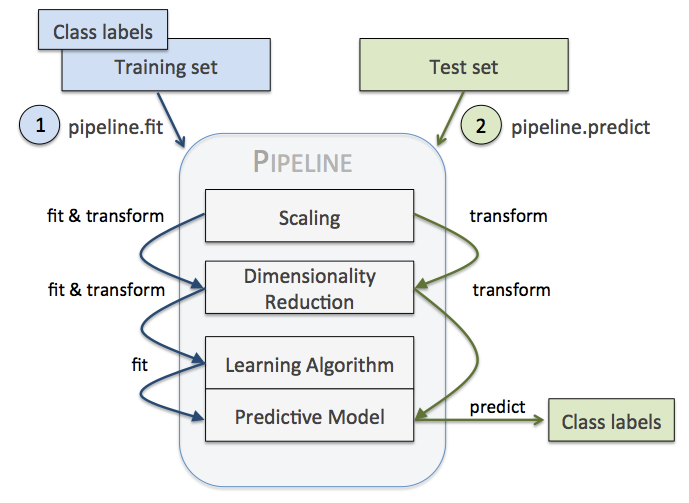


In [30]:
# 1. Importación de librerías y definición del Transformer que integra clustering y mapeo interactivo con sugerencia de etiqueta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.decomposition import PCA

# Importamos modelos para la fase supervisada
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Modelos adicionales: XGBoost, LightGBM y CatBoost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import warnings

warnings.filterwarnings('ignore')  # Ignora todos los warnings

# Función para guardar pipeline
def save_pipeline(pipeline, filename='customer_segmentation_pipeline.joblib'):
    joblib.dump(pipeline, filename)

# Función para cargar pipeline
def load_pipeline(filename='customer_segmentation_pipeline.joblib'):
    return joblib.load(filename)

# Transformer que realiza:
# - Escalado de los datos (para clustering)
# - Búsqueda del número óptimo de clusters usando silhouette_score
# - Cálculo de los centros de los clusters y, basándose en los nombres de las columnas, sugiere una etiqueta para cada cluster
# - Solicita al usuario, para cada cluster, ingresar una etiqueta (presionando Enter se acepta la sugerencia)
    
class ClusteringAndMapping(BaseEstimator, TransformerMixin):
    def __init__(self, k_range=range(2, 11), random_state=42):
        self.k_range = k_range
        self.random_state = random_state

    def fit(self, X, y=None):
        # Si X es DataFrame, se extraen los nombres de las columnas y se obtiene la matriz numérica
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
            X_numeric = X.values
        else:
            self.feature_names_ = None
            X_numeric = X

        # Escalado de datos
        self.scaler_ = StandardScaler()
        X_scaled = self.scaler_.fit_transform(X_numeric)

        best_score = -1
        best_k = None
        best_model = None

        # Se recorre el rango de k para encontrar el que maximice el silhouette_score
        for k in self.k_range:
            model = KMeans(n_clusters=k, random_state=self.random_state)
            labels = model.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_model = model

        self.best_k_ = best_k
        self.best_model_ = best_model
        print("Número óptimo de clusters encontrado:", best_k)

        # Calcular centros de clusters (en espacio escalado)
        self.centers_ = self.best_model_.cluster_centers_
        
        # Sugerir una etiqueta para cada cluster:
        self.mapping_ = {}
        print("\n--- Sugerencias de Etiquetas para cada Cluster ---")
        for cluster in range(self.best_k_):
            center = self.centers_[cluster]
            # Si se tienen nombres de columnas, se busca la característica con mayor valor absoluto
            if self.feature_names_ is not None:
                idx = np.argmax(np.abs(center))
                feature = self.feature_names_[idx]
                if center[idx] >= 0:
                    suggestion = f'Alto {feature}'
                else:
                    suggestion = f'Bajo {feature}'
            else:
                suggestion = f'Cluster {cluster}'
            # Solicitar input interactivo al usuario
            user_input = input(f"Para el cluster {cluster} se sugiere: '{suggestion}'. Ingrese la etiqueta deseada (o presione Enter para aceptar): ")
            self.mapping_[cluster] = user_input if user_input.strip() != "" else suggestion

        print("\nMapping final:", self.mapping_)
        return self

    def transform(self, X):
        # Se asegura de aplicar el mismo escalado
        if hasattr(X, 'columns'):
            X_numeric = X.values
        else:
            X_numeric = X
        X_scaled = self.scaler_.transform(X_numeric)
        # Se predicen los clusters usando el modelo óptimo encontrado
        cluster_labels = self.best_model_.predict(X_scaled)
        # Se mapea cada cluster a la etiqueta definida por el usuario o sugerida
        mapped_labels = np.array([self.mapping_[label] for label in cluster_labels])
        return mapped_labels
    

In [31]:
def evaluate_clusters(X, labels, centers):
    # Silhouette score
    sil_score = silhouette_score(X, labels)
    
    # Davies-Bouldin score
    from sklearn.metrics import davies_bouldin_score
    db_score = davies_bouldin_score(X, labels)
    
    # Calculate cluster sizes
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    # Feature importance per cluster
    feature_importance = pd.DataFrame(
        centers,
        columns=X.columns
    ).apply(lambda x: np.abs(x - x.mean()) / x.std())
    
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Score: {db_score:.3f}")
    print("\nCluster Sizes:")
    print(cluster_sizes)
    print("\nTop Features per Cluster:")
    for i in range(len(centers)):
        top_features = feature_importance.iloc[i].nlargest(3)
        print(f"\nCluster {i} - Top Features:")
        print(top_features)

def analyze_cluster_profiles(df, labels):
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = labels
    
    profiles = []
    for cluster in np.unique(labels):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]
        profile = {
            'Cluster': cluster,
            'Size': len(cluster_data),
            'Avg_Age': cluster_data['Age'].mean(),
            'Spending_Distribution': cluster_data['Spending_Score'].value_counts(normalize=True),
            'Top_Professions': cluster_data['Profession'].value_counts().nlargest(3),
            'Married_Ratio': (cluster_data['Ever_Married'] == 'Yes').mean(),
            'Graduated_Ratio': (cluster_data['Graduated'] == 'Yes').mean()
        }
        profiles.append(profile)
    
    return profiles

def analyze_feature_importance(pipeline, X):
    # Obtener datos transformados
    preprocessed_data = pipeline.named_steps['preprocessor'].transform(X)
    feature_selected_data = pipeline.named_steps['feature_selector'].transform(preprocessed_data)
    
    # Obtener nombres de características
    numeric_features = ['Age', 'Work_Experience', 'Family_Size', 'Spending_Power']
    categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Age_Group']
    
    # Obtener nombres de características después de one-hot encoding
    cat_encoder = pipeline.named_steps['feature_selector'].named_transformers_['cat']
    categorical_features_encoded = cat_encoder.get_feature_names_out(categorical_features)
    
    # Combinar nombres de características
    all_features = numeric_features + categorical_features_encoded.tolist()
    
    # Obtener centroides de clusters
    cluster_centers = pipeline.named_steps['clustering_mapping'].best_model_.cluster_centers_
    
    # Calcular importancia de características por cluster
    for i, center in enumerate(cluster_centers):
        print(f"\nCluster {i} - Características más importantes:")
        # Calcular la distancia desde la media global
        importance = np.abs(center - np.mean(feature_selected_data, axis=0))
        # Obtener top 5 características
        top_features_idx = np.argsort(importance)[-5:]
        for idx in top_features_idx[::-1]:
            print(f"{all_features[idx]}: {importance[idx]:.3f}")

In [32]:
df = pd.read_csv('D:\Git\Team_Challenge_Pipelines\Train.csv')
test_df = pd.read_csv('D:\Git\Team_Challenge_Pipelines\Test.csv')
# For train data
print("Train data info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# For test data
print("\nTest data info:")
print(test_df.info())
print("\nFirst few rows:")
print(test_df.head())

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
None

First few rows:
       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healthcare              1.0   
1  462643  Female          Yes

Original columns: ['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Segmentation']
Columns after dropping ID and Segmentation: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns in input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns after preprocessing: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Age_Group', 'Spending_Power']
Número óptimo de clusters encontrado: 6

--- Sugerencias de Etiquetas para cada Cluster ---

Mapping final: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}
Columns in input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns after preprocessing: ['Gender', 'Ev

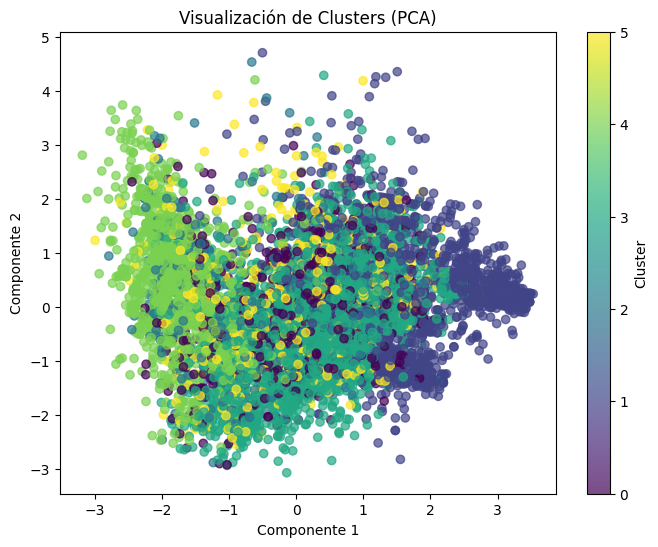

Silhouette Score: 0.102

Cluster 0:
Tamaño: 914 clientes
Edad promedio: 43.1
Profesiones principales:
Profession
Entertainment    914
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
Low        0.614880
Average    0.346827
High       0.038293
Name: proportion, dtype: float64

Cluster 1:
Tamaño: 1389 clientes
Edad promedio: 66.0
Profesiones principales:
Profession
Lawyer       611
Executive    558
Artist       156
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
High       0.584593
Low        0.302376
Average    0.113031
Name: proportion, dtype: float64

Cluster 2:
Tamaño: 683 clientes
Edad promedio: 37.0
Profesiones principales:
Profession
Doctor    683
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
Low        0.702782
Average    0.259151
High       0.038067
Name: proportion, dtype: float64

Cluster 3:
Tamaño: 2757 clientes
Edad promedio: 44.6
Profesiones principales:
Profession
Artist       2293
Homemaker     170
Marketing     104
Name

In [34]:
# 1. Primero definimos el DataPreprocessor
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_features = ['Age', 'Work_Experience', 'Family_Size']
        self.cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        
        # Debug print
        print("Columns in input data:", X_copy.columns.tolist())
        
        # Handle missing values
        # Numerical: median imputation
        for col in self.num_features:
            if col in X_copy.columns:
                X_copy[col].fillna(X_copy[col].median(), inplace=True)
        
        # Categorical: mode imputation
        for col in self.cat_features:
            if col in X_copy.columns:
                X_copy[col].fillna(X_copy[col].mode()[0], inplace=True)
        
        # Add feature engineering
        X_copy['Age_Group'] = pd.cut(X_copy['Age'], 
                                    bins=[0, 25, 35, 50, 65, 100],
                                    labels=['Young', 'Young_Adult', 'Adult', 'Senior', 'Elder'])
        
        # Convert Spending_Score to numeric
        spending_map = {'Low': 1, 'Average': 2, 'High': 3}
        X_copy['Spending_Power'] = X_copy['Spending_Score'].map(spending_map)
        
        # Debug print
        print("Columns after preprocessing:", X_copy.columns.tolist())
        
        return X_copy

# 2. Cargar y preparar los datos
df = pd.read_csv('D:\Git\Team_Challenge_Pipelines\Train.csv')

# Debug print
print("Original columns:", df.columns.tolist())

# 3. Preparar los datos para el clustering
X = df.drop(['ID', 'Segmentation'], axis=1)

# Debug print
print("Columns after dropping ID and Segmentation:", X.columns.tolist())

# 4. Crear y aplicar el pipeline
pipeline_unsupervised = Pipeline(steps=[
    ('preprocessor', DataPreprocessor()),
    ('feature_selector', ColumnTransformer([
        ('num', StandardScaler(), ['Age', 'Work_Experience', 'Family_Size', 'Spending_Power']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), 
         ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Age_Group'])
    ])),
    ('clustering_mapping', ClusteringAndMapping(k_range=range(2, 8), random_state=42))
])

# 5. Ajustar el pipeline y obtener etiquetas
try:
    target_labels = pipeline_unsupervised.fit_transform(X)
    df['target'] = target_labels
except KeyError as e:
    print(f"KeyError encontrado: {e}")
    print("Columnas esperadas vs. columnas disponibles:")
    expected_cols = ['Age', 'Work_Experience', 'Family_Size', 'Spending_Power', 
                     'Gender', 'Ever_Married', 'Graduated', 'Profession', 'Age_Group']
    available_cols = X.columns.tolist()
    print("Esperadas:", expected_cols)
    print("Disponibles:", available_cols)

# Visualización de los clusters usando PCA
# 1. Obtener los datos transformados
preprocessed_data = pipeline_unsupervised.named_steps['preprocessor'].transform(X)
feature_selected_data = pipeline_unsupervised.named_steps['feature_selector'].transform(preprocessed_data)

# 2. Aplicar PCA sobre los datos transformados
pca = PCA(n_components=2)
components = pca.fit_transform(feature_selected_data)  # Convertir matriz dispersa a densa

# 3. Obtener las etiquetas de los clusters
clusters = pipeline_unsupervised.named_steps['clustering_mapping'].best_model_.labels_

# 4. Visualizar
plt.figure(figsize=(8,6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Visualización de Clusters (PCA)')
plt.colorbar(label='Cluster')
plt.show()

# 5. Mostrar métricas de evaluación
# Calcular el silhouette score usando los datos transformados
silhouette_avg = silhouette_score(feature_selected_data, clusters)
print(f'Silhouette Score: {silhouette_avg:.3f}')

# 6. Analizar perfiles de clusters
profiles = analyze_cluster_profiles(df, clusters)
for profile in profiles:
    print(f"\nCluster {profile['Cluster']}:")
    print(f"Tamaño: {profile['Size']} clientes")
    print(f"Edad promedio: {profile['Avg_Age']:.1f}")
    print("Profesiones principales:")
    print(profile['Top_Professions'])
    print("Distribución de Gastos:")
    print(profile['Spending_Distribution'])

analyze_feature_importance(pipeline_unsupervised, X)

# Interpretación de Resultados del Clustering

## Calidad del Clustering
El Silhouette Score de 0.102 es relativamente bajo (rango de -1 a 1), indicando que los clusters no están muy bien separados. Esto es común en datos del mundo real donde las características se solapan.

## Análisis por Cluster

### Cluster 0 - "Profesionales del Entretenimiento"
- **Tamaño**: 914 clientes (11.3%)
- **Perfil**: 
  * 100% trabajan en Entretenimiento
  * Edad media de 43.1 años
  * Mayoría con gastos bajos (61.5%) o medios (34.7%)
  * Características distintivas: Entretenimiento, mayoría mujeres y graduados

### Cluster 1 - "Profesionales Senior de Alto Gasto"
- **Tamaño**: 1,389 clientes (17.2%)
- **Perfil**:
  * Principalmente abogados (44%) y ejecutivos (40%)
  * Edad media alta: 66 años
  * Alto nivel de gasto (58.5%)
  * Características distintivas: Edad avanzada, solteros, profesiones de alto estatus

### Cluster 2 - "Médicos Conservadores"
- **Tamaño**: 683 clientes (8.5%)
- **Perfil**:
  * 100% doctores
  * Edad media de 37 años
  * Predominantemente gasto bajo (70.3%)
  * Características distintivas: Profesión médica, casados, graduados

### Cluster 3 - "Artistas de Gasto Moderado"
- **Tamaño**: 2,757 clientes (34.2%)
- **Perfil**:
  * Mayoría artistas (83%)
  * Edad media de 44.6 años
  * Gastos distribuidos entre bajo (50.8%) y medio (39.5%)
  * Características distintivas: No graduados, solteros, predominio masculino

### Cluster 4 - "Jóvenes Profesionales de la Salud"
- **Tamaño**: 1,629 clientes (20.2%)
- **Perfil**:
  * Principalmente sector salud (76%)
  * Muy jóvenes (26.2 años promedio)
  * Gasto predominantemente bajo (98%)
  * Características distintivas: Casados, graduados, sector salud, muy jóvenes

### Cluster 5 - "Ingenieros"
- **Tamaño**: 696 clientes (8.6%)
- **Perfil**:
  * 100% ingenieros
  * Edad media de 41.6 años
  * Mayoría gasto bajo (60%) o medio (31.8%)
  * Características distintivas: Ingenieros, hombres, graduados

## Recomendaciones de Marketing por Cluster

### 1. Cluster 1 (Alto valor)
- Enfoque en productos/servicios premium
- Programas de fidelización exclusivos
- Marketing dirigido a profesionales senior

### 2. Cluster 4 (Jóvenes profesionales)
- Productos de entrada/básicos
- Ofertas para primeras compras
- Marketing en redes sociales

### 3. Cluster 3 (Artistas)
- Productos de precio medio
- Ofertas creativas/culturales
- Marketing enfocado en valor por dinero

### 4. Clusters 0, 2, 5 (Profesionales especializados)
- Marketing segmentado por profesión
- Productos específicos para cada sector
- Programas de beneficios por sector